# Estimate Industrial Production Elasticities 

In [1]:
# can comment out warnings.filterwarnings if you want to see warnings
import warnings
warnings.filterwarnings("ignore")

import sys
dir_git = "/Users/usuario/git/sisepuede"
if dir_git not in sys.path:
    sys.path.append(dir_git)

import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede.core.attribute_table as att
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.utilities.data_support._elasticities as elast
import sisepuede.utilities._toolbox as sf
import utils.common_data_needs as cdn
import time
from typing import *

plt.style.use("dark_background", )



[juliapkg] Found dependencies: /Users/usuario/git/sisepuede/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/sisepuede/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/sisepuede/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ^1.11.5
[juliapkg] Installing Julia 1.11.6 using JuliaUp
[juliapkg] Using Julia 1.11.5 at /Users/usuario/.juliaup/bin/julia
[juliapkg] Using Julia project at /Users/usuario/git/sisepuede/sisepuede/julia
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="Cbc", uuid="9961bab8-2fa3-5c5a-9d89-47fab24efd76"), Pkg.PackageSpec(name="Clp", uuid="e2554f3b-3117-50c0-817c-e040a3ddf72d"), Pkg.PackageSpec(name="DataFrames", uuid="a93c6f00-e57d-5684-b7b6-d8193f3e46c0"), Pkg.PackageSpec(name="GLPK", uuid="60bf3e95-4087-53dc-ae20-288a0d20c6a6"), Pkg.Packa

The latest version of Julia in the `release` channel is 1.11.6+0.aarch64.apple.darwin14. You currently have `1.11.5+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.6+0.aarch64.apple.darwin14 and update the `release` channel to that version.
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/git/sisepuede/sisepuede/julia/Project.toml`
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.2.2
  [a93c6f00] + DataFrames v1.7.0
  [60bf3e95] + GLPK v1.2.1
  [87dc4568] + HiGHS v1.18.2
  [b6b21f68] + Ipopt v1.10.6
  [4076af6c] + JuMP v1.27.0
  [a3c327a0] + NemoMod v2.0.0 `https://github.com/sei-international/NemoMod.jl.git#61e63e0`
⌅ [6099a3de] + PythonCall v0.9.22
  [0aa819cd] + SQLite v1.6.1
    Updating `~/git/sisepuede/sisepuede/julia/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.6.0
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.2.2
  [523fee87] + CodecBzip2 v0.8.5
  [944b1d66]

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1293.4 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [2]:
importlib.reload(cdn)
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# setup region
_REGION_NAME = "uganda"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso")



##  Get latest inputs to use for estimating elasticities

In [161]:
# set to 100 here since we'll use it to estimate the elasticities
df_inputs = cdn._build_from_outputs(
    (
        min(time_periods.all_years), 
        max(time_periods.all_years)
    ),
    fns_exclude = ["frac_lndu_initial.csv"],
    merge_type = "outer", 
    print_info = False,
    stop_on_error = True, 
)

# add year back in
df_inputs = time_periods.tps_to_years(df_inputs, )
df_inputs[regions.field_iso] = _REGION_ISO


In [162]:
model_ippu = models.model_ippu

# retrieve initial production; then, time period after final unique row is first to project with
modvar_prod_init = matt.get_variable(model_ippu.modvar_ippu_prod_qty_init, )
df_ext = (
    modvar_prod_init
        .get_from_dataframe(
        df_inputs, 
        fields_additional = [time_periods.field_time_period],
    )
    .drop_duplicates(
        subset = modvar_prod_init.fields, 
    )
)

# estimate the first year needed for projecting
time_period_project_first = int(float(df_ext[time_periods.field_time_period].max() + 1))




# Use the `exogenous_demands_to_sispeuede_ies` estimator for getting elasticities

In [168]:
modvar_elast = matt.get_variable(model_ippu.modvar_ippu_elast_ind_prod_to_gdp, )
modvar_gdp = matt.get_variable(model_ippu.model_socioeconomic.modvar_econ_gdp, )
modvar_prod = matt.get_variable(model_ippu.modvar_ippu_qty_total_production, )
modvar_prodinit = matt.get_variable(model_ippu.modvar_ippu_prod_qty_init, )
modvar_scalar = matt.get_variable(model_ippu.modvar_ippu_scalar_production, )


df_prodscalar, df_elasticities, df_prodinit = elast.exogenous_demands_to_sispeuede_ies(
    df_inputs,
    matt,
    modvar_prodinit,  # model_ippu.modvar_ippu_prod_qty_init,
    modvar_gdp,       # model_ippu.model_socioeconomic.modvar_econ_gdp,
    modvar_elast,     # model_ippu.modvar_ippu_elast_ind_prod_to_gdp,
    modvar_scalar,    # model_ippu.modvar_ippu_scalar_production,
    time_period_project_first,
    elasticity_bounds = (-0.5, 2.0),
    elasticity_default = 1.0,
    field_iso = regions.field_iso,
    max_dev_from_mean = 0.2,
    sup_elast_magnitude = 10**3,
    stop_on_error = True,
)


# inputs that can be tested
df_inputs2 = sf.match_df_to_target_df(
    df_inputs,
    df_elasticities,
    fields_index = [
        regions.field_iso,
        time_periods.field_year
    ]
)




In [169]:
df_prodinit.head()

,year,iso_alpha_3,prodinit_ippu_cement_tonne,prodinit_ippu_chemicals_tonne,prodinit_ippu_electronics_tonne,prodinit_ippu_glass_tonne,prodinit_ippu_lime_and_carbonite_tonne,prodinit_ippu_metals_tonne,prodinit_ippu_mining_tonne,prodinit_ippu_paper_tonne,prodinit_ippu_plastic_tonne,prodinit_ippu_rubber_and_leather_tonne,prodinit_ippu_textiles_tonne,prodinit_ippu_wood_tonne
0,2015,UGA,2557000.0,50906.963930,50493.790280,6978.867111,99844.366790,453038.410300,448252.569400,188071.411100,82221.103820,6740.876602,17640.297200,1.424851e+06
1,2016,UGA,2557000.0,38383.850803,57562.920919,7962.887374,113922.422507,414530.145424,511007.929116,206502.409388,93732.058355,6882.435011,18010.743441,1.564486e+06
2,2017,UGA,2557000.0,28941.423506,65621.729848,9085.654493,129985.484081,379295.083063,582549.039192,226739.645508,106854.546524,7026.966146,18388.969053,1.717806e+06
3,2018,UGA,2557000.0,21821.833323,74808.772027,10366.731777,148313.437336,347055.001003,664105.904679,248960.130768,121814.183038,7174.532435,18775.137404,1.886151e+06
4,2019,UGA,3071000.0,26469.883821,77202.652731,10636.266803,152169.586707,336643.350973,685357.293629,227549.559522,125712.236895,8587.915325,22473.839472,1.723942e+06


In [176]:
#[x for x in dir(model_ippu) if "modvar_ippu" in x]


In [188]:
df_out = model_ippu(df_inputs, )
df_out2 = model_ippu(df_inputs2, )


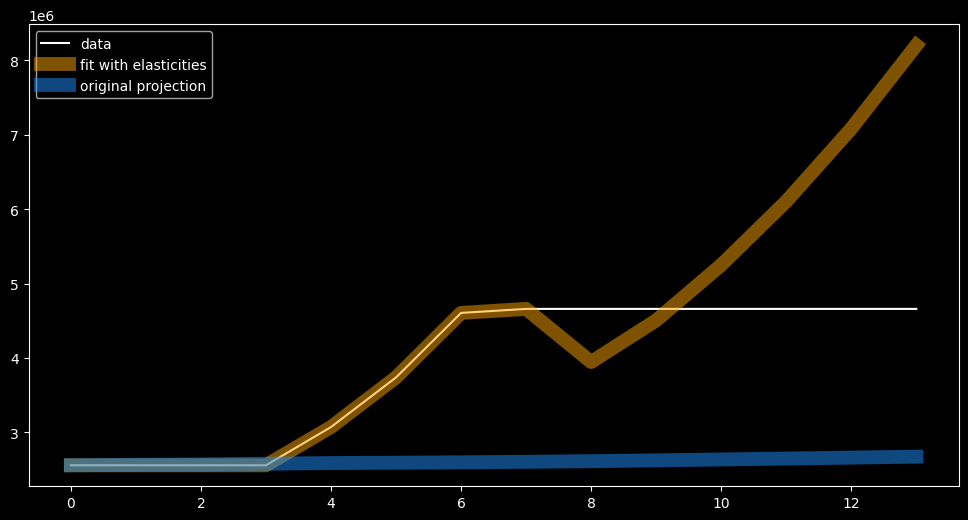

In [189]:
fig, ax = plt.subplots(figsize = (12, 6))

cat = "cement"# "lime_and_carbonite"
fld_init = modvar_prodinit.build_fields(category_restrictions = cat, )
fld_est = modvar_prod.build_fields(category_restrictions = cat, )

ax.plot(df_prodinit[fld_init].iloc[0:14].values, c = "white", label = "data", )
ax.plot(df_out2[fld_est].iloc[0:14].values, c = "orange", alpha = 0.5, linewidth = 10, label = "fit with elasticities")
ax.plot(df_out[fld_est].iloc[0:14].values, c = "dodgerblue", alpha = 0.5, linewidth = 10, label = "original projection")
ax.legend()

# Plot elasticities
- Note, only will go as far as model projects, which is based on 2070

<Axes: xlabel='year'>

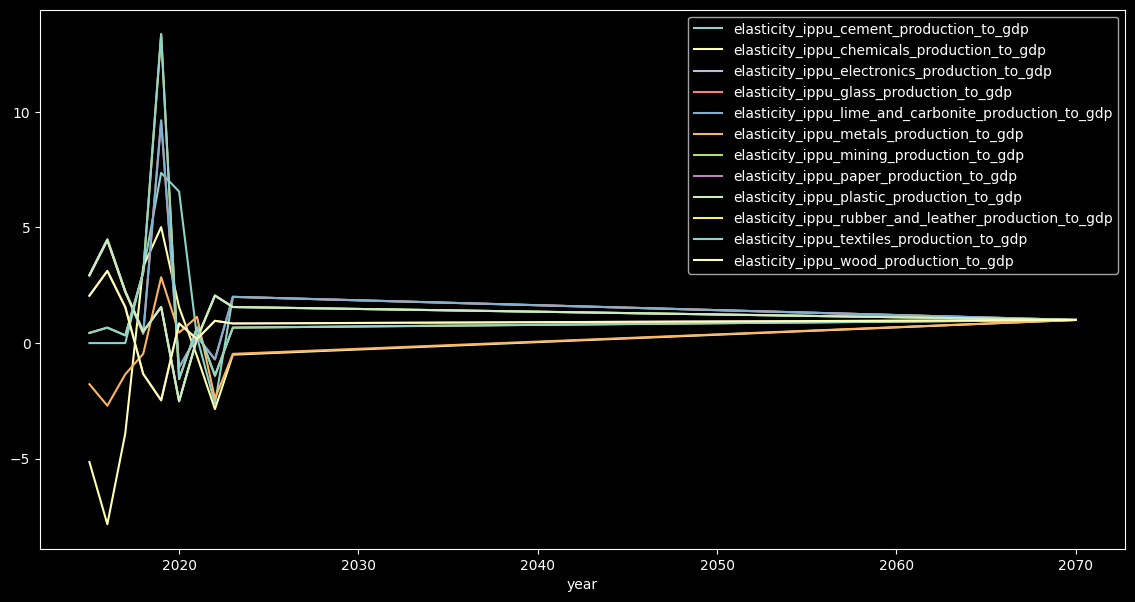

In [172]:
fig, ax = plt.subplots(figsize = (14, 7))
(
    df_elasticities
    .drop(columns = [regions.field_iso])
    .plot(ax = ax, x = time_periods.field_year)
)

# Export

In [194]:

# WRITE ELASTICITIES TO CSV
df_elasticities.to_csv(
    cdn._PATH_OUTPUTS.joinpath(f"{modvar_elast.name_fs_safe.upper()}.csv"),
    encoding = "UTF-8",
    index = None,
)

# WRITE PRODUCTION SCALAR
df_prodscalar.to_csv(
    cdn._PATH_OUTPUTS.joinpath(f"{modvar_scalar.name_fs_safe.upper()}.csv"),
    encoding = "UTF-8",
    index = None,
)





In [165]:
df_elasticities["elasticity_ippu_cement_production_to_gdp"]

0     0.000000
1     0.000000
2     0.000000
3     3.119712
4     7.364751
5     6.555662
6     0.255918
7    -2.624498
8     2.000000
9     1.978723
10    1.957447
11    1.936170
12    1.914894
13    1.893617
14    1.872340
15    1.851064
16    1.829787
17    1.808511
18    1.787234
19    1.765957
20    1.744681
21    1.723404
22    1.702128
23    1.680851
24    1.659574
25    1.638298
26    1.617021
27    1.595745
28    1.574468
29    1.553191
30    1.531915
31    1.510638
32    1.489362
33    1.468085
34    1.446809
35    1.425532
36    1.404255
37    1.382979
38    1.361702
39    1.340426
40    1.319149
41    1.297872
42    1.276596
43    1.255319
44    1.234043
45    1.212766
46    1.191489
47    1.170213
48    1.148936
49    1.127660
50    1.106383
51    1.085106
52    1.063830
53    1.042553
54    1.021277
55    1.000000
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

## Plot emissions stack for quick gut check

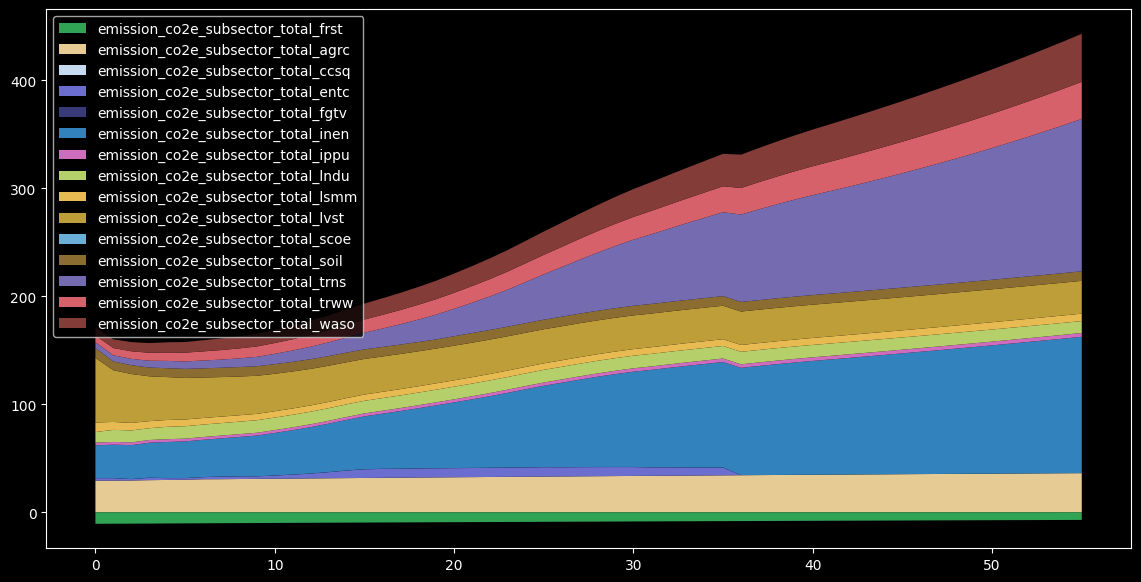

In [61]:
import sisepuede.plotting.plots as spp

fig, ax = plt.subplots(figsize = (14, 7))

spp.plot_emissions_stack(
    df_run,
    matt,
    figtuple = (fig, ax), 
)

ax.legend()



<Axes: xlabel='year'>

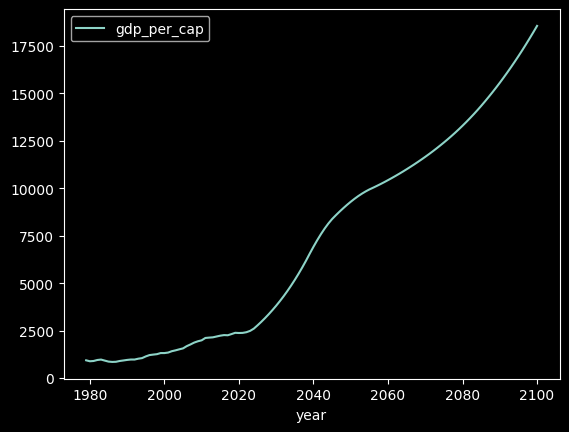

In [145]:
_FIELD_GDP_CAP = "gdp_per_cap"
_FIELD_POP = "population"



df_gdp = pd.read_csv(cdn._PATH_OUTPUTS.joinpath("GDP.csv"))
df_pop = pd.read_csv(cdn._PATH_OUTPUTS.joinpath("POPULATION.csv"))

df_pop[_FIELD_POP] = df_pop[["population_gnrl_rural", "population_gnrl_urban"]].sum(axis = 1, )

df_compare = pd.merge(
    df_gdp,
    df_pop,
    how = "inner",
)


# CWATM @ IIASA (community water model)

df_compare[_FIELD_GDP_CAP] = (10**9)*df_compare["gdp_mmm_usd"].to_numpy()/df_compare[_FIELD_POP].to_numpy()
df_compare[[time_periods.field_year, _FIELD_GDP_CAP]].plot(x = time_periods.field_year, )

